In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

def random_search(model, param_distributions, X, y, n_iter=100, cv=5):
    best_score = -np.inf
    best_params = None
    history = []

    skf = StratifiedKFold(n_splits=cv)

    for _ in range(n_iter):
        params = {key: np.random.choice(values) for key, values in param_distributions.items()}
        model.set_params(**params)
        scores = []
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train)
            y_pred = model.predict_proba(X_test)
            for i in range(y_pred.shape[1]):
                scores.append(roc_auc_score(y_test == i, y_pred[:, i]))
        mean_score = np.mean(scores)
        history.append((params, mean_score))

        if mean_score > best_score:
            best_score = mean_score
            best_params = params

    return best_params, best_score, history


In [ ]:
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

class BayesianOptimization:
    def __init__(self, model, param_distributions, X, y, n_iter=25, cv=5):
        self.model = model
        self.param_distributions = param_distributions
        self.X = X
        self.y = y
        self.n_iter = n_iter
        self.cv = cv
        self.gpr = GaussianProcessRegressor(kernel=Matern(nu=2.5), alpha=1e-6, normalize_y=True)
        self.history = []

    def propose_location(self):
        best_score = -np.inf
        best_params = None
        for _ in range(100):
            params = {key: np.random.choice(values) for key, values in self.param_distributions.items()}
            if 'classifier__max_depth' in params and params['classifier__max_depth'] is None:
                params['classifier__max_depth'] = 1000

            if len(self.history) > 0:
                mean, std = self.gpr.predict([list(params.values())], return_std=True)
                score = mean + 1.96 * std
                if score > best_score:
                    best_score = score
                    best_params = params
            else:
                best_params = params

        return best_params

    def optimize(self):
        for _ in range(self.n_iter):
            if len(self.history) > 0:
                X_train = np.array([list(params.values()) for params, score in self.history])
                y_train = np.array([score for params, score in self.history])
                self.gpr.fit(X_train, y_train)

            params = self.propose_location()
            self.model.set_params(**params)
            scores = cross_val_score(self.model, self.X, self.y, cv=self.cv, scoring='accuracy')
            mean_score = np.mean(scores)
            self.history.append((params, mean_score))

        best_params, best_score = max(self.history, key=lambda item: item[1])
        return best_params, best_score


In [ ]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

def run_optimization(model, param_distributions, X, y, method='bayesian', n_iter=25, cv=5):
    if method == 'random':
        return random_search(model, param_distributions, X, y, n_iter=n_iter, cv=cv)
    elif method == 'bayesian':
        optimizer = BayesianOptimization(model, param_distributions, X, y, n_iter=n_iter, cv=cv)
        return optimizer.optimize()
    else:
        raise ValueError("Unsupported optimization method")

# Example usage
data = load_iris()
X, y = data.data, data.target

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])

param_distributions = {
    'classifier__n_estimators': [10, 50, 100],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

best_params, best_score = run_optimization(pipeline, param_distributions, X, y, method='bayesian', n_iter=10)
print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'classifier__n_estimators': 100, 'classifier__max_depth': 10, 'classifier__min_samples_split': 10}
Best Score: 0.9666666666666668


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def preprocess_data(X):
    numeric_features = [0, 1, 2, 3]
    categorical_features = []

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='mean'), numeric_features),
            ('num_scaler', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(), categorical_features)
        ])

    return preprocessor.fit_transform(X)

X_preprocessed = preprocess_data(X)
best_params, best_score, history = run_optimization(pipeline, param_distributions, X_preprocessed, y, method='random', n_iter=10)
print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'classifier__n_estimators': 100, 'classifier__max_depth': None, 'classifier__min_samples_split': 5}
Best Score: 0.996


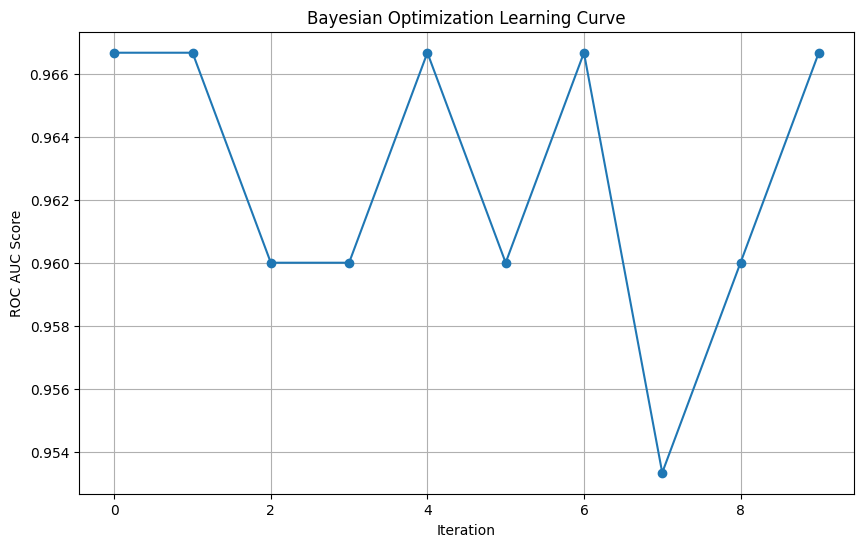

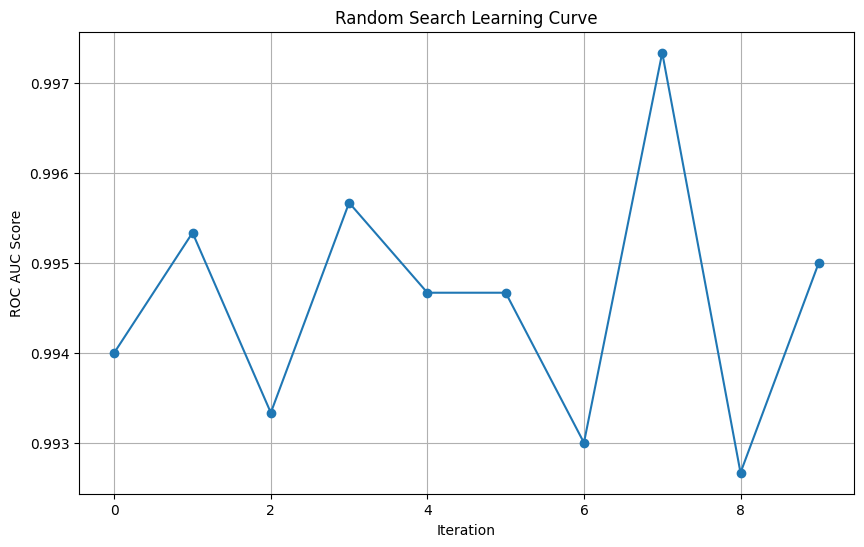

In [ ]:
import matplotlib.pyplot as plt

def plot_learning_curves(history, title):
    iterations = range(len(history))
    scores = [score for params, score in history]

    plt.figure(figsize=(10, 6))
    plt.plot(iterations, scores, marker='o')
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('ROC AUC Score')
    plt.grid(True)
    plt.show()

# Example usage
data = load_iris()
X, y = data.data, data.target

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])

param_distributions = {
    'classifier__n_estimators': [10, 50, 100],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

# Bayesian Optimization
optimizer = BayesianOptimization(pipeline, param_distributions, X, y, n_iter=10)
best_params, best_score = optimizer.optimize()
plot_learning_curves(optimizer.history, 'Bayesian Optimization Learning Curve')

# Random Search
best_params, best_score, history = random_search(pipeline, param_distributions, X, y, n_iter=10)
plot_learning_curves(history, 'Random Search Learning Curve')
